# Naive Seasonal Baseline

#### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from matplotlib import pyplot as plt
from utilsforecast.evaluation import evaluate

from darts import TimeSeries
from pandas import DataFrame

configure logging output

In [3]:
from rich.logging import RichHandler
import logging

logging.basicConfig(level=logging.INFO, handlers=[RichHandler()])

using default YAML but overwriting the relative data path

In [4]:
initialize(
    version_base=None,
    config_path="../configs",
)
cfg = compose(
    config_name="train_ltsf.yaml",
    overrides=["dataset.datamodule.path=/workspaces/ai4healthcare/data/external/kispp"],
)

/usr/local/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'train_ltsf.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


#### Replication of Training Pipeline Steps

###### Resolve Hydra Config

In [5]:
from src import pipelines

datamodule, _, _ = pipelines.resolve_config(cfg)

2024-04-24 09:11:32,094	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-24 09:11:32,203	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


[04/24/24 09:11:34] INFO     INFO:src.pipelines:Loaded Config:                                     ]8;id=688757;file:///workspaces/ai4healthcare/src/pipelines.py\pipelines.py]8;;\:]8;id=377182;file:///workspaces/ai4healthcare/src/pipelines.py#665\665]8;;\

                    INFO     INFO:src.utils:Global seed set to 123                                   ]8;id=175756;file:///workspaces/ai4healthcare/src/utils/__init__.py\__init__.py]8;;\:]8;id=781455;file:///workspaces/ai4healthcare/src/utils/__init__.py#94\94]8;;\

                    INFO     INFO:src.pipelines:Instantiating datamodule                           ]8;id=279501;file:///workspaces/ai4healthcare/src/pipelines.py\pipelines.py]8;;\:]8;id=112931;file:///workspaces/ai4healthcare/src/pipelines.py#672\672]8;;\
                             <src.data.kispp_datamodule.KisppDataModule>                                           

                    INFO     INFO:src.pipelines:Instantiating model                                ]8;id=562248;file:///workspaces/ai4healthcare/src/pipelines.py\pipelines.py]8;;\:]8;id=589633;file:///workspaces/ai4healthcare/src/pipelines.py#675\675]8;;\
                             <neuralforecast.models.DLinear>                                                       

                    INFO     INFO:lightning_fabric.utilities.seed:Seed set to 123                        ]8;id=353597;file:///usr/local/lib/python3.10/site-packages/lightning_fabric/utilities/seed.py\seed.py]8;;\:]8;id=588211;file:///usr/local/lib/python3.10/site-packages/lightning_fabric/utilities/seed.py#54\54]8;;\

                    INFO     INFO:src.pipelines:No logger has been initialized.                    ]8;id=279501;file:///workspaces/ai4healthcare/src/pipelines.py\pipelines.py]8;;\:]8;id=112931;file:///workspaces/ai4healthcare/src/pipelines.py#696\696]8;;\

##### run LTSF pipeline
get dataset from datamodule. 

this reads the various KISPP excel files and does all the preprocessing (take a look into `src.data.uka.kispp.staff_data` if you're interested) and finally aggregates them in the given frequency, in the way our time series forecasting expects it, with 1 identifier column `unique_id` and one numerical column `y`.

In [6]:
Y_df = datamodule.pipeline()
futr_df = datamodule.futr_exog

[04/24/24 09:11:35] INFO     INFO:root:trying to load or build `staff_matrix_*` dataframe              ]8;id=589633;file:///workspaces/ai4healthcare/src/data/utils.py\utils.py]8;;\:]8;id=348334;file:///workspaces/ai4healthcare/src/data/utils.py#200\200]8;;\

                    INFO     INFO:root:Load Dataframe staff_matrix_*                                   ]8;id=353597;file:///workspaces/ai4healthcare/src/data/utils.py\utils.py]8;;\:]8;id=588211;file:///workspaces/ai4healthcare/src/data/utils.py#264\264]8;;\

                    INFO     INFO:root:dataframe not found -> rebuilding                               ]8;id=949910;file:///workspaces/ai4healthcare/src/data/utils.py\utils.py]8;;\:]8;id=457468;file:///workspaces/ai4healthcare/src/data/utils.py#208\208]8;;\

found staff file: /workspaces/ai4healthcare/data/external/kispp/uka_staff_matrix_231121.xlsx
found header file to read dkeys: /workspaces/ai4healthcare/data/external/kispp/uka_personnel_indexed.xlsx
found shift abbrv. file: /workspaces/ai4healthcare/data/external/kispp/list_of_abbreviations_231116.xlsx
Reading sheet 8.5 1. HJ 23
Reading sheet 8.5 2 HJ 22
Reading sheet 8.5 1. HJ 22
Reading sheet 8.8 1 HJ 23
Reading sheet 8.8 2 HJ 22
Reading sheet 8.8 1 HJ 22
Reading sheet 9.7  1. HJ 23
Reading sheet 9.7 2. HJ 22
Reading sheet 9.7 1. HJ 22
Reading sheet 10.3 1 HJ 23
Reading sheet 10.3 2 HJ 22
Reading sheet 10.3 1 HJ 22
Reading sheet 11.0 2023
Reading sheet 11.0 2022
Reading sheet 11.4 1. HJ 22
Reading sheet 11.4 1. HJ 23
Reading sheet 11.4 2. HJ 22


processing sheet 8.5 1. HJ 23:   0%|          | 0/17 [00:00<?, ?it/s]

[04/24/24 09:11:54] INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=6915;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=330782;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=97270;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=699545;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

[04/24/24 09:11:55] INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=305976;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=955410;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=878536;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=38528;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 8.5 2 HJ 22:   6%|▌         | 1/17 [00:00<00:08,  1.79it/s] 

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=840430;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=506421;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=552678;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=592250;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=936316;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=806647;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=564678;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=669361;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 8.5 1. HJ 22:  12%|█▏        | 2/17 [00:01<00:08,  1.83it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=873999;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=509751;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=534843;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=33388;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

[04/24/24 09:11:56] INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=761085;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=860031;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=274608;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=178390;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 8.8 1 HJ 23:  18%|█▊        | 3/17 [00:01<00:07,  1.87it/s] 

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=926853;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=76850;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=816566;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=352432;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=871999;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=658838;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=240259;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=425427;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 8.8 2 HJ 22:  24%|██▎       | 4/17 [00:02<00:06,  2.07it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=953316;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=62627;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=660593;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=755284;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

[04/24/24 09:11:57] INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=161230;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=562435;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=46273;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=10645;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 8.8 1 HJ 22:  29%|██▉       | 5/17 [00:02<00:05,  2.05it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=268815;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=837695;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=665078;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=440776;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=535109;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=372308;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=941075;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=8977;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 9.7  1. HJ 23:  35%|███▌      | 6/17 [00:02<00:05,  2.17it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=573133;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=727927;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

[04/24/24 09:11:58] INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=275293;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=495463;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=434185;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=365289;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=926815;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=439393;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 9.7 2. HJ 22:  41%|████      | 7/17 [00:03<00:05,  1.69it/s] 

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=150978;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=390185;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=864820;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=921602;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=406017;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=563647;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=809974;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=960310;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 9.7 1. HJ 22:  47%|████▋     | 8/17 [00:04<00:04,  1.81it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=386387;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=132613;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

[04/24/24 09:11:59] INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=660201;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=174904;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=65070;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=777372;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=366518;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=471569;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 10.3 1 HJ 23:  53%|█████▎    | 9/17 [00:04<00:04,  1.87it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=745565;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=701323;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=811937;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=29630;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=541948;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=539722;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=109867;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=571953;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 10.3 2 HJ 22:  59%|█████▉    | 10/17 [00:05<00:03,  1.85it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=597882;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=356600;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

[04/24/24 09:12:00] INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=255054;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=213146;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=45114;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=983839;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=209190;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=794941;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 10.3 1 HJ 22:  65%|██████▍   | 11/17 [00:05<00:03,  1.74it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=281280;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=592051;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=87808;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=357715;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

[04/24/24 09:12:01] INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=933767;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=848318;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=945703;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=507467;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 11.0 2023:  71%|███████   | 12/17 [00:06<00:02,  1.76it/s]   

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=29595;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=269328;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=909274;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=509733;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=881160;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=525606;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=6250;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=941902;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 11.0 2022:  76%|███████▋  | 13/17 [00:07<00:02,  1.58it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=518494;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=360075;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

[04/24/24 09:12:02] INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=54982;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=378164;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=897372;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=441200;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=470859;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=359696;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 11.4 1. HJ 22:  82%|████████▏ | 14/17 [00:08<00:02,  1.42it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=189452;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=400948;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

[04/24/24 09:12:03] INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=393567;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=524785;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=897928;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=586185;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=310272;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=128268;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 11.4 1. HJ 23:  88%|████████▊ | 15/17 [00:08<00:01,  1.52it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=634861;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=337886;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=614432;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=407285;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=802784;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=740652;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=278831;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=881694;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 11.4 2. HJ 22:  94%|█████████▍| 16/17 [00:09<00:00,  1.60it/s]

                    INFO     INFO:src.data.uka.kispp.staff_data:processing multiline rows         ]8;id=260480;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=994876;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#815\815]8;;\

[04/24/24 09:12:04] INFO     INFO:src.data.uka.kispp.staff_data:re-pivoting dataframes            ]8;id=949446;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=967863;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#839\839]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:processing footer (patient/staff  ]8;id=129330;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=20879;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#844\844]8;;\
                             aggregations)                                                                         

                    INFO     INFO:src.data.uka.kispp.staff_data:merging shift details             ]8;id=138296;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=500508;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#850\850]8;;\

processing sheet 11.4 2. HJ 22: 100%|██████████| 17/17 [00:09<00:00,  1.73it/s]


[04/24/24 09:12:06] INFO     INFO:src.data.uka.kispp.staff_data:resampling demand/supply data      ]8;id=341669;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=912751;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#67\67]8;;\
                             accoring to: D rule                                                                   

[04/24/24 09:12:08] INFO     INFO:root:trying to load or build `interval_staff_capacity_*` dataframe   ]8;id=626723;file:///workspaces/ai4healthcare/src/data/utils.py\utils.py]8;;\:]8;id=905905;file:///workspaces/ai4healthcare/src/data/utils.py#200\200]8;;\

                    INFO     INFO:root:Load Dataframe interval_staff_capacity_*                        ]8;id=953374;file:///workspaces/ai4healthcare/src/data/utils.py\utils.py]8;;\:]8;id=930635;file:///workspaces/ai4healthcare/src/data/utils.py#264\264]8;;\

                    INFO     INFO:src.data.uka.kispp.staff_data:found public holidays file:       ]8;id=608283;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=944678;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#456\456]8;;\
                             /workspaces/ai4healthcare/data/external/kispp/public_holidays_1.json                  

                    INFO     INFO:src.data.uka.kispp.staff_data:found school holidays file:       ]8;id=721409;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py\staff_data.py]8;;\:]8;id=930847;file:///workspaces/ai4healthcare/src/data/uka/kispp/staff_data.py#464\464]8;;\
                             /workspaces/ai4healthcare/data/external/kispp/school_holidays_240325                  
                             .json                                                                                 

found influenza occurrences file: /workspaces/ai4healthcare/data/external/kispp/IfSG_Influenzafaelle (1).tsv
found are/ili occurences file: /workspaces/ai4healthcare/data/external/kispp/GrippeWeb_Daten_des_Wochenberichts.tsv


[04/24/24 09:12:10] INFO     INFO:root:Saved to                                                        ]8;id=436267;file:///workspaces/ai4healthcare/src/data/utils.py\utils.py]8;;\:]8;id=374997;file:///workspaces/ai4healthcare/src/data/utils.py#285\285]8;;\
                             /workspaces/ai4healthcare/data/processed/kispp/exog_interval_staff_capaci             
                             ty_20240424.feather                                                                   

                    INFO     INFO:src.data.kispp_datamodule:Finished building KISPP         ]8;id=172773;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py\kispp_datamodule.py]8;;\:]8;id=207870;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py#134\134]8;;\
                             Datamodule.                                                                           

                    INFO     INFO:src.data.kispp_datamodule:care capacity timeseries head:  ]8;id=772405;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py\kispp_datamodule.py]8;;\:]8;id=971918;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py#135\135]8;;\

                    INFO     INFO:src.data.kispp_datamodule:                   ds   y       ]8;id=907724;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py\kispp_datamodule.py]8;;\:]8;id=918827;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py#136\136]8;;\
                             Pflege Station 10.3 II. Med._planned_absences_personnel_count                         
                             Pflege Station 10.3 II.                                                               
                             Med._unplanned_absences_personnel_count  Pflege Station                               
                             11.1_11.4_worked_personnel_count  Pflege Station                                      
                             11.1_11.4_planned_absences_personnel_count  Pflege Station                            
                             11.1_11.4_unplanned_absences_personnel_count  Pflege Station                          
                             9.7 UCH_worked_personnel_count  Pflege Station 9.7                                    
                             UCH_planned_absences_personnel_count  Pflege Station 9.7                              
                             UCH_unplanned_absences_personnel_count  Pflege Station 8.5/8.8                        
                             I. Med._worked_personnel_count  Pflege Station 8.5/8.8 I.                             
                             Med._planned_absences_personnel_count  Pflege Station 8.5/8.8                         
                             I. Med._unplanned_absences_personnel_count  public_holiday                            
                             school_holiday  influenza_incidence  ARE_incidence                                    
                             ILI_incidence  sin_day_of_week  cos_day_of_week                                       
                             sin_day_of_year  cos_day_of_year  sin_day_of_month                                    
                             cos_day_of_month  sin_month_of_year  cos_month_of_year                                
                             sin_hour_of_day  cos_hour_of_day                     unique_id                        
                             0 2022-01-01 12:00:00   9                                                             
                             50                                                                                    
                             5                                               12                                    
                             38                                                                                    
                             5                                              7                                      
                             38                                                          3                         
                             9                                                                                     
                             32                                                                                    
                             1               1               1                 0.14                                
                             2761            373                5        -0.222521                                 
                             0.017213         0.999852          0.201299           0.97953                         
                             0.5           0.866025     1.224647e-16        -1.000000                              
                             Pflege Station 10.3 II. Med.                                                          
                             1 2022-01-01 13:00:00  14                                                             
                             50                                                                                    


                    INFO     INFO:src.data.kispp_datamodule:future exogenous timeseries     ]8;id=108242;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py\kispp_datamodule.py]8;;\:]8;id=464217;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py#137\137]8;;\
                             head:                                                                                 

                    INFO     INFO:src.data.kispp_datamodule:                   ds  Pflege   ]8;id=204785;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py\kispp_datamodule.py]8;;\:]8;id=546000;file:///workspaces/ai4healthcare/src/data/kispp_datamodule.py#138\138]8;;\
                             Station 10.3 II. Med._planned_absences_personnel_count  Pflege                        
                             Station 11.1_11.4_planned_absences_personnel_count  Pflege                            
                             Station 9.7 UCH_planned_absences_personnel_count  Pflege                              
                             Station 8.5/8.8 I. Med._planned_absences_personnel_count                              
                             public_holiday  school_holiday  sin_day_of_week                                       
                             cos_day_of_week  sin_day_of_year  cos_day_of_year                                     
                             sin_day_of_month  cos_day_of_month  sin_month_of_year                                 
                             cos_month_of_year  sin_hour_of_day  cos_hour_of_day                                   
                             unique_id                                                                             
                             0 2022-01-01 00:00:00                                                                 
                             50                                                         38                         
                             38                                                                                    
                             32               1               1                5                                   
                             -0.222521         0.017213         0.999852          0.201299                         
                             0.97953                0.5           0.866025         0.000000                        
                             1.000000  Pflege Station 10.3 II. Med.                                                
                             1 2022-01-01 01:00:00                                                                 
                             50                                                         38                         
                             38                                                                                    
                             32               1               1                5                                   
                             -0.222521         0.017213         0.999852          0.201299                         
                             0.97953                0.5           0.866025         0.258819                        
                             0.965926  Pflege Station 10.3 II. Med.                                                
                             2 2022-01-01 02:00:00                                                                 
                             50                                                         38                         
                             38                                                                                    
                             32               1               1                5                                   
                             -0.222521         0.017213         0.999852          0.201299                         
                             0.97953                0.5           0.866025         0.500000                        
                             0.866025  Pflege Station 10.3 II. Med.                                                
                             3 2022-01-01 03:00:00                                                                 
                             50                                                         38                         


In [7]:
data_kwargs = dict(
    df=Y_df,
    verbose=cfg.verbose > 0,
    h=cfg.evaluation.horizon,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    futr_df=futr_df,
    static_df=None,
)

visualize dataset

In [8]:
Y_df.head(3)

,ds,y,Pflege Station 10.3 II. Med._planned_absences_personnel_count,Pflege Station 10.3 II. Med._unplanned_absences_personnel_count,Pflege Station 11.1_11.4_worked_personnel_count,Pflege Station 11.1_11.4_planned_absences_personnel_count,Pflege Station 11.1_11.4_unplanned_absences_personnel_count,Pflege Station 9.7 UCH_worked_personnel_count,Pflege Station 9.7 UCH_planned_absences_personnel_count,Pflege Station 9.7 UCH_unplanned_absences_personnel_count,...,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day,unique_id
0,2022-01-01 12:00:00,9,50,5,12,38,5,7,38,3,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,1.224647e-16,-1.000000,Pflege Station 10.3 II. Med.
1,2022-01-01 13:00:00,14,50,8,20,38,6,12,38,4,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,-2.588190e-01,-0.965926,Pflege Station 10.3 II. Med.
2,2022-01-01 14:00:00,14,50,8,20,38,6,12,38,4,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,-5.000000e-01,-0.866025,Pflege Station 10.3 II. Med.


configure evaluation

get callables from metric names

In [9]:
from src.models.evaluation import get_metric
from rich.pretty import pprint

eval_cfg = cfg.evaluation
metrics = {k: get_metric(k) for k in eval_cfg.metrics}
pprint(metrics)

{
│   'mae': <function mae at 0x7fa4e0f1ec20>,
│   'rmse': <function rmse at 0x7fa4e0f1ed40>,
│   'smape': <function smape at 0x7fa4e0f1eef0>
}

Train a NaiveSeasonal model with K=24, corresponding to daily seasonality

In [10]:
from darts.models import NaiveSeasonal

In [11]:
modelDaily = NaiveSeasonal(K=24)

In [12]:
from src.data import utils

kwargs = {}
test_start_date = "2023-04-01"  # eval
df_train, df_test = utils.split_train_test(Y_df, test_start_date)
test_start_date = df_test.iloc[0]["ds"]
kwargs["test_start"] = test_start_date
print(f"train shape: {df_train.shape}")
print(f"test split start: {test_start_date}")
print(
    f"test split shape: {df_test.shape}, which is {len(df_test) / len(Y_df):.1%} of the total dataset."
)

debug: received test split start fixed date: 2023-04-01 00:00:00
train shape: (10908, 29)
test split start: 2023-04-01 00:00:00
test split shape: (2161, 29), which is 16.5% of the total dataset.


In [13]:
train_series = TimeSeries.from_dataframe(
    df_train, time_col="ds", value_cols="y", freq=cfg.dataset.freq
)
train_series

<TimeSeries (DataArray) (ds: 10908, component: 1, sample: 1)> Size: 87kB
array([[[ 9.]],

       [[14.]],

       [[14.]],

       ...,

       [[13.]],

       [[ 5.]],

       [[ 5.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 87kB 2022-01-01T12:00:00 ... 2023-03-31T23...
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [14]:
# --- fit model ---
modelDaily.fit(
    series=train_series,
)

NaiveSeasonal(K=24)

In [15]:
df = TimeSeries.from_dataframe(Y_df, time_col="ds", value_cols="y", freq=cfg.dataset.freq)

----

evaluate

```python
# ed paper
    # Adjust testbench
    if MODEL in ['hwam', 'hwmm', 'hwdm', 'arimax', 'sn']:
        train_length = 24*7
        retrain = True
```

In [16]:
import pandas as pd

l_timeseries = modelDaily.historical_forecasts(
    series=df,
    start=test_start_date,
    forecast_horizon=cfg.evaluation.horizon,
    stride=cfg.evaluation.horizon,
    last_points_only=False,
    verbose=True,
    show_warnings=True,
    retrain=True,
)
if isinstance(l_timeseries, list):
    ts_df = pd.concat([t.pd_dataframe() for t in l_timeseries])
else:
    ts_df = l_timeseries.pd_dataframe()
print("historical_forecasts output:")
ts_df

  0%|          | 0/3 [00:00<?, ?it/s]

historical_forecasts output:


component,y
ds,
2023-04-01 00:00:00,5.0
2023-04-01 01:00:00,5.0
2023-04-01 02:00:00,5.0
2023-04-01 03:00:00,5.0
2023-04-01 04:00:00,5.0
...,...
2023-06-29 19:00:00,9.0
2023-06-29 20:00:00,13.0
2023-06-29 21:00:00,13.0


In [17]:
ts_df = ts_df.reset_index()
ts_df = ts_df.rename(columns={"y": "NaiveSeasonalDaily"})
ts_df = ts_df.merge(df_test, how="left", on="ds")
ts_df

,ds,NaiveSeasonalDaily,y,Pflege Station 10.3 II. Med._planned_absences_personnel_count,Pflege Station 10.3 II. Med._unplanned_absences_personnel_count,Pflege Station 11.1_11.4_worked_personnel_count,Pflege Station 11.1_11.4_planned_absences_personnel_count,Pflege Station 11.1_11.4_unplanned_absences_personnel_count,Pflege Station 9.7 UCH_worked_personnel_count,Pflege Station 9.7 UCH_planned_absences_personnel_count,...,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day,unique_id
0,2023-04-01 00:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.000000,1.000000,Pflege Station 10.3 II. Med.
1,2023-04-01 01:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.258819,0.965926,Pflege Station 10.3 II. Med.
2,2023-04-01 02:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.500000,0.866025,Pflege Station 10.3 II. Med.
3,2023-04-01 03:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.707107,0.707107,Pflege Station 10.3 II. Med.
4,2023-04-01 04:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.866025,0.500000,Pflege Station 10.3 II. Med.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2023-06-29 19:00:00,9.0,8,47,7,8,64,7,7,29,...,-0.900969,0.043022,-0.999074,-0.394356,0.918958,1.224647e-16,-1.0,-0.965926,0.258819,Pflege Station 10.3 II. Med.
2156,2023-06-29 20:00:00,13.0,13,47,8,12,64,7,7,29,...,-0.900969,0.043022,-0.999074,-0.394356,0.918958,1.224647e-16,-1.0,-0.866025,0.500000,Pflege Station 10.3 II. Med.
2157,2023-06-29 21:00:00,13.0,13,47,8,12,64,7,8,29,...,-0.900969,0.043022,-0.999074,-0.394356,0.918958,1.224647e-16,-1.0,-0.707107,0.707107,Pflege Station 10.3 II. Med.
2158,2023-06-29 22:00:00,4.0,5,47,8,4,64,7,3,29,...,-0.900969,0.043022,-0.999074,-0.394356,0.918958,1.224647e-16,-1.0,-0.500000,0.866025,Pflege Station 10.3 II. Med.


In [18]:
metrics

{'mae': <function utilsforecast.losses.mae(df: Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame], models: List[str], id_col: str = 'unique_id', target_col: str = 'y') -> Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame]>,
 'rmse': <function utilsforecast.losses.rmse(df: Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame], models: List[str], id_col: str = 'unique_id', target_col: str = 'y') -> Union[float, numpy.ndarray]>,
 'smape': <function utilsforecast.losses.smape(df: Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame], models: List[str], id_col: str = 'unique_id', target_col: str = 'y') -> Union[float, numpy.ndarray]>}

In [20]:
evaluate(ts_df, metrics=list(metrics.values()), models=["NaiveSeasonalDaily"])

,unique_id,metric,NaiveSeasonalDaily
0,Pflege Station 10.3 II. Med.,mae,2.553241
1,Pflege Station 10.3 II. Med.,rmse,4.041738
2,Pflege Station 10.3 II. Med.,smape,0.103219


Let's try weekly seasonality 

In [33]:
modelWeekly = NaiveSeasonal(K=168)

In [34]:
# --- fit model ---
modelWeekly.fit(
    series=train_series,
)

NaiveSeasonal(K=168)

In [35]:
l_timeseries = modelWeekly.historical_forecasts(
    series=df,
    start=test_start_date,
    forecast_horizon=cfg.evaluation.horizon,
    stride=cfg.evaluation.horizon,
    last_points_only=False,
    verbose=True,
    show_warnings=True,
    retrain=True,
)
if isinstance(l_timeseries, list):
    ts_df = pd.concat([t.pd_dataframe() for t in l_timeseries])
else:
    ts_df = l_timeseries.pd_dataframe()
print("historical_forecasts output:")
ts_df

  0%|          | 0/3 [00:00<?, ?it/s]

historical_forecasts output:


component,y
ds,
2023-04-01 00:00:00,5.0
2023-04-01 01:00:00,5.0
2023-04-01 02:00:00,5.0
2023-04-01 03:00:00,5.0
2023-04-01 04:00:00,5.0
...,...
2023-06-29 19:00:00,8.0
2023-06-29 20:00:00,13.0
2023-06-29 21:00:00,13.0


In [36]:
ts_df = ts_df.reset_index()
ts_df = ts_df.rename(columns={"y": "NaiveSeasonalWeekly"})
ts_df = ts_df.merge(df_test, how="left", on="ds")
ts_df

,ds,NaiveSeasonalWeekly,y,Pflege Station 10.3 II. Med._planned_absences_personnel_count,Pflege Station 10.3 II. Med._unplanned_absences_personnel_count,Pflege Station 11.1_11.4_worked_personnel_count,Pflege Station 11.1_11.4_planned_absences_personnel_count,Pflege Station 11.1_11.4_unplanned_absences_personnel_count,Pflege Station 9.7 UCH_worked_personnel_count,Pflege Station 9.7 UCH_planned_absences_personnel_count,...,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day,unique_id
0,2023-04-01 00:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.000000,1.000000,Pflege Station 10.3 II. Med.
1,2023-04-01 01:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.258819,0.965926,Pflege Station 10.3 II. Med.
2,2023-04-01 02:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.500000,0.866025,Pflege Station 10.3 II. Med.
3,2023-04-01 03:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.707107,0.707107,Pflege Station 10.3 II. Med.
4,2023-04-01 04:00:00,5.0,5,31,13,4,51,11,3,32,...,-0.222521,0.999991,0.004304,0.201299,0.979530,8.660254e-01,-0.5,0.866025,0.500000,Pflege Station 10.3 II. Med.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2023-06-29 19:00:00,8.0,8,47,7,8,64,7,7,29,...,-0.900969,0.043022,-0.999074,-0.394356,0.918958,1.224647e-16,-1.0,-0.965926,0.258819,Pflege Station 10.3 II. Med.
2156,2023-06-29 20:00:00,13.0,13,47,8,12,64,7,7,29,...,-0.900969,0.043022,-0.999074,-0.394356,0.918958,1.224647e-16,-1.0,-0.866025,0.500000,Pflege Station 10.3 II. Med.
2157,2023-06-29 21:00:00,13.0,13,47,8,12,64,7,8,29,...,-0.900969,0.043022,-0.999074,-0.394356,0.918958,1.224647e-16,-1.0,-0.707107,0.707107,Pflege Station 10.3 II. Med.
2158,2023-06-29 22:00:00,6.0,5,47,8,4,64,7,3,29,...,-0.900969,0.043022,-0.999074,-0.394356,0.918958,1.224647e-16,-1.0,-0.500000,0.866025,Pflege Station 10.3 II. Med.


<Axes: >

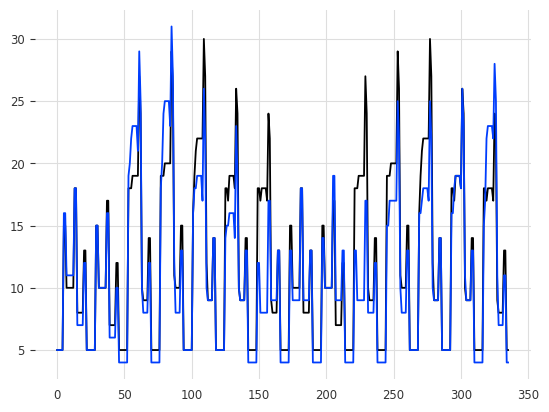

In [37]:
ts_df["NaiveSeasonalWeekly"][0:336].plot()
ts_df["y"][0:336].plot()

In [38]:
evaluate(ts_df, metrics=list(metrics.values()), models=["NaiveSeasonalWeekly"])

,unique_id,metric,NaiveSeasonalWeekly
0,Pflege Station 10.3 II. Med.,mae,1.563889
1,Pflege Station 10.3 II. Med.,rmse,2.519553
2,Pflege Station 10.3 II. Med.,smape,0.066155
